In [60]:
# deep learning 
import tensorflow as tf 
# import tensorflow._api.v2.compat.v1 as tf
# tf.disable_v2_behavior()
tf.compat.v1.disable_eager_execution()
from tensorflow import keras
from tensorflow.keras.callbacks import TensorBoard
import keras.backend as K
from keras.engine.topology import Layer
from keras.layers import GaussianNoise, Dense, Activation, Input
from keras.models import Model
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
from scipy.optimize import linear_sum_assignment as linear_assignment
# general tools
import os
import random
from datetime import datetime
import numpy as np
from tqdm import tqdm
from preprocess import *
from io import *


# os.chdir("..")
# check current working directory
print("Current Working Directory: ", os.getcwd())

# list files in the current directory
print("Files in Current Directory: ", os.listdir())

# check if eager executation is enabled
print("Eager execution: {}".format(tf.executing_eagerly()))


Current Working Directory:  /Users/yufeideng/Documents/GitHub/bis687-project
Files in Current Directory:  ['.DS_Store', 'pytest.ini', 'LICENSE', 'requirements.txt', 'sc-env', 'demo.ipynb', 'reproducibility', 'docs', 'README.md', 'results', 'proposal', 'iterative', '.gitignore', 'scripts', 'dca', '.git', 'LICENSE.txt', 'data', 'scDMFK', 'clustering.ipynb']
Eager execution: False


In [45]:
MeanAct = lambda x: tf.clip_by_value(x, 1e-5, 1e6)
DispAct = lambda x: tf.clip_by_value(tf.nn.softplus(x), 1e-4, 1e4)


def _nan2zero(x):
    return tf.where(tf.math.is_nan(x), tf.zeros_like(x), x)

def _nan2inf(x):
    return tf.where(tf.math.is_nan(x), tf.zeros_like(x)+np.inf, x)

def _nelem(x):
    nelem = tf.reduce_sum(tf.cast(~tf.math.is_nan(x), tf.float32))
    return tf.cast(tf.where(tf.equal(nelem, 0.), 1., nelem), x.dtype)

def _reduce_mean(x):
    nelem = _nelem(x)
    x = _nan2zero(x)
    return tf.divide(tf.reduce_sum(x), nelem)

class wMSE(object):
    def __init__(self, x, type='weighted MSE'):
        self.x = x
        self.type = type
    
    def loss(self, y_true, y_pred):
        weight_loss = self.x * tf.square(y_true - y_pred)
        return weight_loss
    
class mMSE(wMSE): 
    def __init__(self, type='masked MSE', **kwds):
        super().__init__(**kwds)
        self.type = type
    
    def loss(self, y_true, y_pred):
        mask_loss = tf.sign(self.x) * tf.square(y_true - y_pred)
        return tf.reduce_mean(mask_loss)

    
class MultiNom(object):
    def __init__(self, mode='direct'):
        self.mode=mode
    
    def loss(self, y_true, y_pred):
        result = tf.reduce_mean(-y_true * tf.math.log(tf.clip_by_value(y_pred, 1e-12, 1.0)))
        return result

class IndirMultiNom(object):
    def __init__(self, mode='indirect'):
        # self.pi = pi
        self.mode = mode
    
    def loss(self, y_true, y_pred):
        # Compute P using y_pred(V) and pi
        # P = tf.transpose(tf.transpose(self.pi * y_pred) / tf.reduce_sum(self.pi * y_pred, axis=1))
        loss = tf.reduce_mean(-y_true * tf.math.log(tf.clip_by_value(y_pred, 1e-12, 1.0)))
        return loss


class NB(object):
    def __init__(self, theta=None, scale_factor=1.0, mask=False, debug=False, mean=False):
        self.eps = 1e-10
        self.scale_factor = scale_factor
        self.debug = debug
        self.mask = mask
        self.theta = theta
        self.mean = mean
    
    def loss(self, y_true, y_pred):
        mean = self.mean
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.cast(y_pred, tf.float32) * self.scale_factor
        eps = self.eps
        theta = tf.minimum(self.theta, 1e6)
        
        if self.mask:
            nelem = _nelem(y_true)
            y_true = _nan2zero(y_true)
            
        t1 = tf.math.lgamma(theta + eps) + tf.math.lgamma(y_true + 1.0) - tf.math.lgamma(y_true + theta + eps)
        t2 = (theta + y_true) * tf.math.log(1.0 + (y_pred / (theta + eps))) + (y_true * (tf.math.log(theta + eps) - tf.math.log(y_pred + eps)))
        if self.debug:
            assert_ops = [tf.verify_tensor_all_finite(y_pred, 'y_pred has inf/nans'),
                        tf.verify_tensor_all_finite(t1, 't1 has inf/nans'),
                        tf.verify_tensor_all_finite(t2, 't2 has inf/nans')]
            with tf.control_dependencies(assert_ops):
                final = t1 + t2
        else:
            final = t1 + t2
        final = _nan2inf(final)
        if mean:
            if self.mask:
                final = tf.divide(tf.reduce_sum(final), nelem)
            else:
                final = tf.reduce_mean(final)
        return final

class ZINB(NB):
    # ZINB is a class representing the Zero-Inflated Negative Binomial (ZINB) loss function.
    # It is particularly useful in the context of count data or over-dispersed data.

    def __init__(self, pi, ridge_lambda=0.0, mean=True, **kwargs):
        super().__init__(mean=mean, **kwargs)
        self.pi = pi
        self.ridge_lambda = ridge_lambda
        
    def loss(self, y_true, y_pred):
        pi = self.pi
        theta = self.theta
        mean = self.mean
        eps = self.eps
        scale_factor = self.scale_factor
        
        nb_case = super().loss(y_true, y_pred) - tf.math.log(1.0 - pi + eps)
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.cast(y_pred, tf.float32) * scale_factor
        theta = tf.minimum(theta, 1e6)

        zero_nb = tf.pow(theta / (theta + y_pred + eps), theta)
        zero_case = -tf.math.log(pi + ((1.0 - pi) * zero_nb) + eps)
        result = tf.where(tf.less(y_true, 1e-8), zero_case, nb_case)
        ridge = self.ridge_lambda * tf.square(pi)
        result += ridge
        if mean:
            if self.mask:
                result = _reduce_mean(result)
            else:
                result = tf.reduce_mean(result)

        result = _nan2inf(result)
        return result


In [92]:
class scDMFK():
    def __init__(self, output_dir, input_size, output_size,
                dims=[256,64,32,64,256], alpha=0.001, sigma=1.0, learning_rate=0.0001,
                theta=1, cluster_num=1, noise_sd=1.5, init='glorot_uniform', act='relu', adaptative = True,
                distribution='multinomial', mode='indirect'):
        # super().__init__()
        self.output_dir = output_dir
        self.input_size = input_size
        self.output_size = output_size
        self.dims = dims
        self.cluster_num = cluster_num
        self.alpha = alpha
        self.sigma = sigma
        self.theta = theta
        self.learning_rate = learning_rate
        self.noise_sd = noise_sd
        self.init = init
        self.act = act
        self.adaptative = adaptative
        self.distribution = distribution
        self.mode = mode
        self.model = None
        self.loss = None
        self.optimizer = None
        
        # print("Creating new scDMFK model")
        # input layer
        self.x =  Input(shape=(self.input_size,), name='original')
        self.x_count = Input(shape=(self.input_size,), name='count')
        self.sf_layer = Input(shape=(1,), name='size_factors')

        # latent layers
        self.h = self.x_count
        self.h = GaussianNoise(self.noise_sd, name='input_noise')(self.h)
        for i, hid_size in enumerate(self.dims):
            center_idx = int(np.floor(len(self.dims) / 2.0))
            if i == center_idx:
                layer_name = 'hidden'
                self.latent = Dense(units=self.dims[-1], kernel_initializer=self.init,
                                    name=layer_name)(self.h)  # hidden layer, features are extracted from here
                self.h = self.latent
            elif i < center_idx:
                layer_name = 'encoder%s' % (i+1)
                self.h = Dense(units=hid_size, kernel_initializer=self.init, name=layer_name)(self.h)
                self.h = GaussianNoise(self.noise_sd, name='noise_%d' % i)(self.h)  # add Gaussian noise
                self.h = Activation(self.act)(self.h)
            else:
                layer_name = 'decoder%s' % (i-center_idx)
                self.h = Dense(units=self.dims[i], activation=self.act, kernel_initializer=self.init, 
                            name=layer_name)(self.h)    
        self.build_output()
        
    def build_output(self):
        
        if self.distribution == "multinomial":
            if self.mode == "indirect":                
                # output layer
                self.mean = Dense(units=self.output_size, activation=MeanAct, kernel_initializer=self.init, name='mean')(self.h)
                self.output = self.mean * tf.matmul(self.sf_layer, tf.ones((1, self.mean.get_shape()[1]), dtype=tf.float32))
                self.pi = Dense(units=self.output_size, activation='sigmoid', kernel_initializer=self.init, name='pi')(self.h)
                self.output = tf.transpose(tf.transpose(self.pi * self.output) / tf.reduce_sum(self.pi * self.output, axis=1))    
                # pi computation as a parallel output
                # self.pi_layer = PiLayer(output_size=self.output_size, activation='sigmoid')
                # self.pi = self.pi_layer(self.h)
                multinom = IndirMultiNom()
            else:
                self.output = Dense(units=self.output_size, activation=tf.nn.softmax, kernel_initializer=self.init, name='pi')(self.h)
                multinom = MultiNom()
            self.loss = multinom.loss
            
        elif self.distribution == "ZINB":       
            self.pi = Dense(units=self.output_size, activation='sigmoid', kernel_initializer=self.init, name='pi')(self.h)
            self.disp = Dense(units=self.output_size, activation=DispAct, kernel_initializer=self.init, name='dispersion')(self.h)
            self.mean = Dense(units=self.output_size, activation=MeanAct, kernel_initializer=self.init, name='mean')(self.h)
            self.output = self.mean * tf.matmul(self.sf_layer, tf.ones((1, self.mean.get_shape()[1]), dtype=tf.float32)) 
            zinb = ZINB(pi=self.pi, theta=self.disp, ridge_lambda=1.0)
            self.loss = zinb.loss
        
        elif self.distribution == "weight mse":
            self.output = Dense(units=self.output_size, kernel_initializer=self.init, name='reconstruction')(self.h)
            # self.weight_mse = weight_mse(self.x_count, self.x, self.recon_x)
            self.loss = wMSE(x=self.x).loss
        else:
            self.output = Dense(units=self.output_size, kernel_initializer=self.init, name='reconstruction')(self.h)
            # self.mask_mse = mask_mse(self.x_count, self.x, self.recon_x)
            self.loss = mMSE(x=self.x).loss

        # put together full model architecture
        self.model = Model(inputs=[self.x, self.x_count, self.sf_layer], outputs=self.output)
        
        # get hidden representation: encoder output
        self.encoder = Model(inputs=self.model.input, outputs=self.model.get_layer('hidden').output)        


    def predict(self, adata, copy=False):        
        adata = adata.copy() if copy else adata

        print('Calculating reconstructions...') 
        prediction = self.model.predict({'original': adata.raw.X,
                                    'count': adata.X,
                                    'size_factors': adata.obs.size_factors})
        if self.distribution == "multinomial":
            adata.X = prediction * adata.raw.X.sum(1)[:, np.newaxis]
        else:
            adata.X = prediction

        print('Calculating hidden representation...')
        adata.obsm['X_hidden'] = self.encoder.predict({'original': adata.raw.X,
                                    'count': adata.X,
                                    'size_factors': adata.obs.size_factors})
        
        return adata if copy else None

    def write(self, adata, colnames=None, rownames=None):  #YD added
        colnames = adata.var_names.values if colnames is None else colnames
        rownames = adata.obs_names.values if rownames is None else rownames 
        
        data_path = self.output_dir
        os.makedirs(data_path, exist_ok=True) 
        filename = 'results-%s.h5ad'%self.distribution
        
        adata.write(os.path.join(data_path, filename), compression='gzip')


    def pretrain(self, adata, size_factor, batch_size=128, pretrain_epoch=300, gpu_option='0',
                 tensorboard=False):
        print("Begin the pretraining...")
        
        # set seed for reproducibility
        random.seed(42)
        np.random.seed(42)
        os.environ['PYTHONHASHSEED'] = '0'
        os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
        os.environ["CUDA_VISIBLE_DEVICES"] = gpu_option

        # Set up the TensorFlow session with specific configurations for parallelism 
        config_ = tf.compat.v1.ConfigProto()
        config_.gpu_options.allow_growth = True
        config_.allow_soft_placement = True
        session = tf.compat.v1.Session(config=config_)
        tf.compat.v1.keras.backend.set_session(session)
        # Initialize variables
        session.run(tf.compat.v1.global_variables_initializer())
        session.run(tf.compat.v1.local_variables_initializer())    
        
        callback = []
        if tensorboard:
            logdir = os.path.join('results', 'tb')
            tensorboard = TensorBoard(log_dir=logdir)    
            callback.append(tensorboard)

        self.optimizer = tf.optimizers.Adam(self.learning_rate)
        self.model.compile(optimizer=self.optimizer, loss=self.loss)
        
        inputs = {'original': adata.raw.X, 'count': adata.X , 'size_factors': size_factor}
        output = adata.raw.X
        
        self.losses = self.model.fit(inputs, output,
                        epochs=pretrain_epoch,
                        batch_size=batch_size,
                        shuffle=True,
                        validation_split=0.2,
                        callbacks=callback,
                        verbose=0)
        
        print("Average loss: ", np.average(self.losses.history['loss']))
    
    def print_summary(self):
        self.model.summary()
        
    def print_train_history(self, save=False): #plot the training history
        import matplotlib.pyplot as plt
        %config InlineBackend.figure_format='retina'

        plt.plot(self.losses.history['loss'], label='Training Loss')
        plt.plot(self.losses.history['val_loss'], label='Validation Loss')
        plt.legend()
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        if save:
            plt.savefig(os.path.join(self.output_dir, 'scdm-history-%s'%(self.distribution)))
        plt.show()


## Denoising: simulation data

Processing: Young
Successfully preprocessed 33658 genes and 5685 cells


/Users/yufeideng/Documents/GitHub/bis687-project/sc-env/lib/python3.8/site-packages/scanpy/preprocessing/_utils.py:11: RuntimeWarning: overflow encountered in multiply
  mean_sq = np.multiply(X, X).mean(axis=axis, dtype=np.float64)


Training: multinomial
Begin the pretraining...


/Users/yufeideng/Documents/GitHub/bis687-project/sc-env/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:2323: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Average loss:  1.8591060267982507
Calculating reconstructions...
Calculating hidden representation...
[[5.2710323e-07 2.2491040e-05 6.6902766e-07 ... 4.7682994e-03
  4.0462652e-07 5.2003050e-04]
 [1.7890436e-06 7.0215344e-07 3.6209777e-08 ... 2.0570138e-04
  2.5799315e-07 5.5131194e-04]
 [7.2580893e-05 5.2795695e-06 5.9021072e-09 ... 9.0577118e-02
  9.2021501e-06 7.6809514e-04]
 [1.2789178e-06 9.8089652e-07 1.3602575e-08 ... 1.4763138e-04
  1.6628130e-07 3.4900577e-04]
 [9.8833812e-07 3.4713496e-05 5.5436828e-07 ... 2.2021126e-02
  2.1916997e-06 2.8124349e-03]]


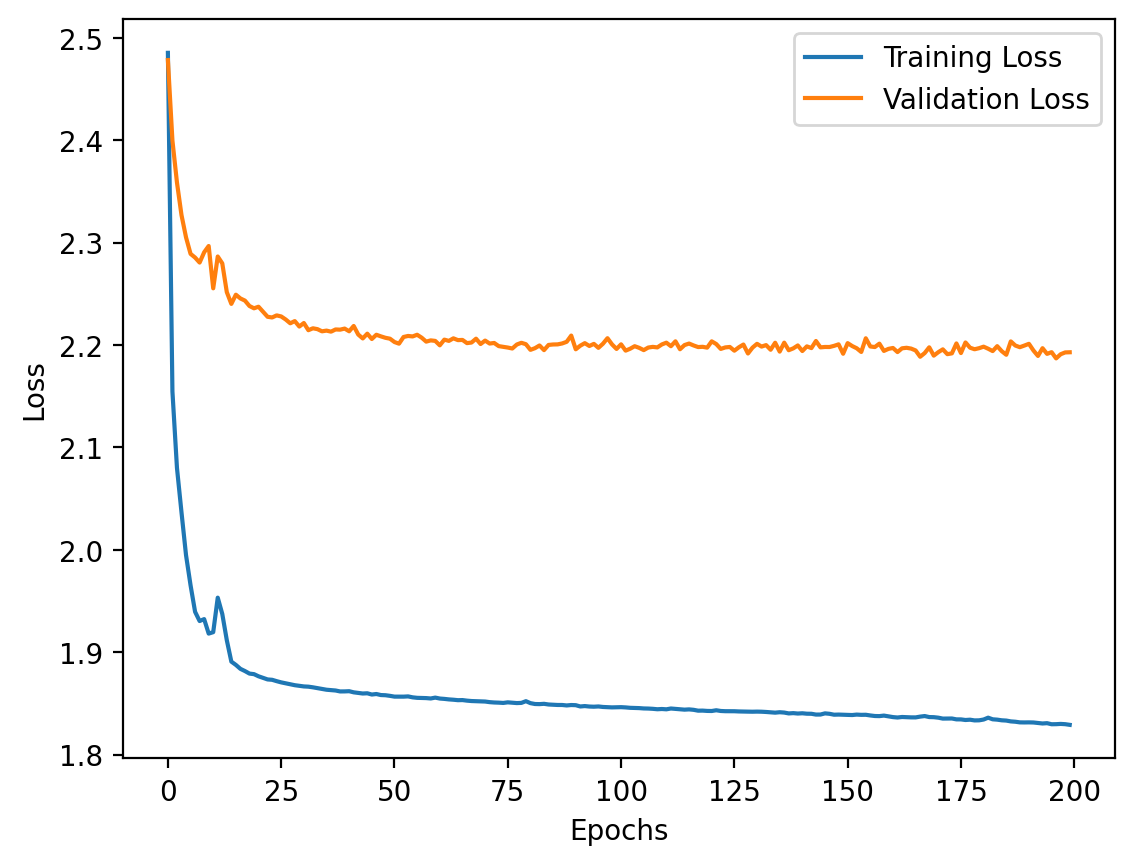

Training: ZINB
Begin the pretraining...


KeyboardInterrupt: 

In [93]:
datanames = [
    'Young','Quake_10x_Bladder','Quake_10x_Limb_Muscle', 'Quake_10x_Spleen',
  #  'group10_dropout1', 'group10_dropout5'
]
methods = ['multinomial','ZINB', 'weight mse', 'mask mse']

for dataname in datanames:
    print('Processing: %s' % dataname)
    out = 'results/' + dataname + '/'
    data_path = dataname + '/data.h5'
    transpose = False
    
    data = prepro(data_path, transpose)
    data = normalize(data)

    input_size = data.n_vars
    output_size = input_size
    size_factor = np.array(data.obs.size_factors).reshape(-1, 1).astype(np.float32)

    for m in methods:
        adata = data.copy()
        print('Training: %s' % m)
        model = scDMFK(output_dir=out,input_size=input_size, output_size=output_size,
                    dims=[64,32,64], learning_rate=0.0005, distribution=m)
        model.pretrain(adata, size_factor, batch_size=128, pretrain_epoch=200)
        model.predict(adata)
        print(adata.X[:5,:])
        model.write(adata)
        model.print_train_history(save=True)

In [76]:
# load simulated data
dataname = 'group10_dropout1/counts.tsv'
output_dir = 'group10_dropout1'
transpose = True
sim1 = prepro(dataname, transpose)
sim1 = normalize(sim1)

input_size = sim1.n_vars
output_size = input_size
size_factor = np.array(sim1.obs.size_factors).reshape(-1, 1).astype(np.float32)

Successfully preprocessed 200 genes and 2000 cells


In [77]:
zinb = scDMFK(
    output_dir='results/group10_dropout1',input_size=input_size, output_size=output_size,
    dims=[64,32,64], learning_rate=0.0005, distribution='ZINB')
zinb.pretrain(sim1, size_factor, batch_size=128, pretrain_epoch=100, gpu_option='0')
zinb.predict(sim1)

Creating new scDMFK model
Begin the pretraining...
Train on 1800 samples, validate on 200 samples
Epoch 1/100


/Users/yufeideng/Documents/GitHub/bis687-project/sc-env/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:2323: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


1800/1800 - 2s - loss: 1342.4121 - val_loss: 1120.8456
Epoch 2/100
1800/1800 - 0s - loss: 891.6831 - val_loss: 724.2812
Epoch 3/100
1800/1800 - 0s - loss: 558.7489 - val_loss: 492.4817
Epoch 4/100
1800/1800 - 0s - loss: 371.2765 - val_loss: 361.1945
Epoch 5/100
1800/1800 - 0s - loss: 259.9039 - val_loss: 286.8418
Epoch 6/100
1800/1800 - 0s - loss: 201.1879 - val_loss: 239.1531
Epoch 7/100
1800/1800 - 0s - loss: 160.0239 - val_loss: 205.5436
Epoch 8/100
1800/1800 - 0s - loss: 134.7058 - val_loss: 183.8565
Epoch 9/100
1800/1800 - 0s - loss: 114.1966 - val_loss: 167.1578
Epoch 10/100
1800/1800 - 0s - loss: 103.1936 - val_loss: 155.8759
Epoch 11/100
1800/1800 - 0s - loss: 92.3600 - val_loss: 145.9250
Epoch 12/100
1800/1800 - 0s - loss: 85.6244 - val_loss: 138.2565
Epoch 13/100
1800/1800 - 0s - loss: 80.1314 - val_loss: 130.8898
Epoch 14/100
1800/1800 - 0s - loss: 74.5095 - val_loss: 124.1965
Epoch 15/100
1800/1800 - 0s - loss: 70.0309 - val_loss: 118.1656
Epoch 16/100
1800/1800 - 0s - loss

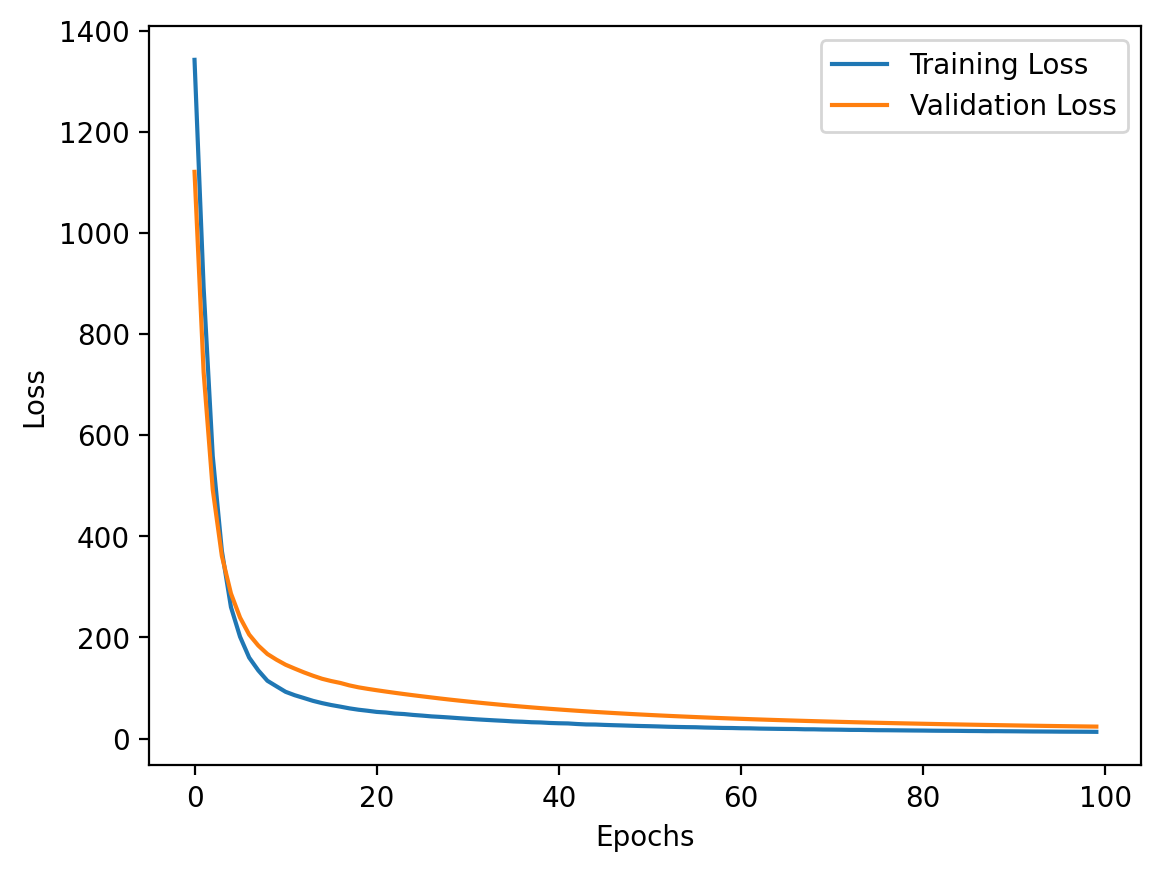

In [78]:
zinb.print_train_history()

In [52]:
pd.DataFrame(sim1.X)

,0,1,2,3,4,5,6,7,8,9,...,189,190,191,192,193,194,195,196,197,198
0,9.236932,3.440368,5.749671,4.693779,10.372546,9.487016,18.334890,6.435522,19.473495,4.651821,...,11.313213,10.288234,18.818604,0.731434,4.912336,8.223145,6.839350,3.813099,2.614857,19.614655
1,5.468112,1.659218,3.814730,3.123067,6.150363,5.535604,11.165462,3.850573,11.744717,2.364002,...,6.404989,5.665302,10.983428,0.380163,2.657233,5.144146,3.698523,2.296307,1.142841,11.505073
2,7.295410,1.816989,4.322442,4.020203,7.281742,6.482594,13.258918,5.461424,13.888680,3.555041,...,9.288069,6.950316,13.932354,0.818072,3.255731,4.851985,5.166821,3.240341,1.683980,14.528437
3,9.836879,3.099688,5.209629,5.750198,8.452984,8.319779,16.666119,6.418504,18.346125,4.834490,...,11.168957,9.024836,17.124622,0.775758,3.377939,6.577843,6.331394,4.195677,2.230436,17.661205
4,5.059892,1.832766,3.528431,2.986511,5.893047,4.996325,9.742074,3.326699,10.894565,2.609836,...,5.837976,4.920083,9.305100,0.610524,2.773126,4.738744,2.822573,2.305315,0.909971,10.123084
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,6.892665,1.845169,3.665350,3.379329,6.466769,5.553259,11.551841,4.513813,11.713070,3.495683,...,7.249651,6.007827,12.279042,0.411538,2.633348,5.368037,3.818506,2.683436,0.940354,12.364549
1996,7.869935,2.285827,4.207164,4.049319,7.751706,7.328610,15.405819,5.593473,14.801655,3.881312,...,10.039421,7.714956,14.579480,0.690606,2.915977,5.116651,5.936278,3.369304,2.040024,16.072769
1997,7.759191,2.166119,4.611842,4.240905,7.398804,7.194386,14.618117,5.335168,16.150393,3.565362,...,10.096045,7.815308,15.171632,0.638898,3.099386,5.971940,5.785883,3.516334,1.718967,15.417109
1998,7.730979,2.213163,3.973110,3.936977,6.776206,6.595955,13.009446,4.425412,14.870975,3.253459,...,8.454635,6.664238,13.205751,0.380610,2.163002,5.570274,4.670903,3.190904,1.363661,14.522338


In [56]:
sim1_label= pd.read_csv('data/group10_dropout1/info_cellinfo.tsv', sep='\t')['Group']
sim1_raw = pd.read_csv('data/group10_dropout1/counts.tsv', sep='\t')# raw data
# raw clustering
sim1_emb = get_embedding(sim1_raw.values)
draw_umap(sim1_emb, sim_label)

,Cell1,Cell2,Cell3,Cell4,Cell5,Cell6,Cell7,Cell8,Cell9,Cell10,...,Cell1991,Cell1992,Cell1993,Cell1994,Cell1995,Cell1996,Cell1997,Cell1998,Cell1999,Cell2000
Gene1,34,43,38,21,30,13,0,10,20,22,...,13,36,0,32,17,12,25,23,36,29
Gene2,98,65,60,56,57,0,79,28,56,65,...,51,67,41,120,38,38,71,59,51,0
Gene3,27,13,5,0,0,15,21,16,12,5,...,3,0,19,0,11,0,27,0,10,3
Gene4,496,312,312,406,254,373,220,154,283,374,...,244,339,306,435,350,278,299,291,310,258
Gene5,33,17,0,16,21,28,5,9,25,0,...,18,16,0,22,0,0,27,24,5,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Gene196,160,160,126,144,105,82,101,0,87,122,...,66,100,109,142,120,67,105,90,77,79
Gene197,383,449,590,436,347,397,428,220,251,449,...,299,402,294,527,382,201,245,322,282,321
Gene198,1262,1416,1547,1279,1030,978,1222,566,990,1356,...,1132,1100,1057,0,784,982,1230,994,1075,935
Gene199,14,0,5,7,7,4,3,0,6,17,...,0,5,0,11,0,0,0,6,0,10


## Endoderm data

In [148]:
# load endoderm data
dataname = "endoderm/endoderm.csv"
output_dir = None
transpose = True
highly_genes = None
highly_subset=False
adata = prepro(dataname, transpose=transpose)

adata = normalize(adata, highly_genes=highly_genes, highly_subset=highly_subset)
high_variable = adata.var.highly_variable

# X = adata.X.astype(np.float32)
# count_X = X
# count_X = count_X[:, high_variable]
input_size = adata.n_vars
output_size = input_size
size_factor = np.array(adata.obs.size_factors).reshape(-1, 1).astype(np.float32)

Successfully preprocessed 1018 genes and 19097 cells


In [156]:
model = scDMFK(output_dir, input_size, output_size, dims=[64,32,64], learning_rate=0.001)
model.pretrain(adata, size_factor, batch_size=128, pretrain_epoch=50, gpu_option='0')

Creating new scDMFK model
begin the pretraining
Train on 916 samples, validate on 102 samples
Epoch 1/50
916/916 [==============================] - 2s 2ms/sample - loss: 2806.7381 - val_loss: 2101.6846
Epoch 2/50


/Users/yufeideng/Documents/GitHub/bis687-project/sc-env/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:2323: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


916/916 [==============================] - 1s 1ms/sample - loss: 2344.8116 - val_loss: 2035.1759
Epoch 3/50
916/916 [==============================] - 1s 1ms/sample - loss: 2284.5329 - val_loss: 2009.5165
Epoch 4/50
916/916 [==============================] - 1s 1ms/sample - loss: 2259.5536 - val_loss: 2002.5903
Epoch 5/50
916/916 [==============================] - 1s 1ms/sample - loss: 2245.4923 - val_loss: 1996.3624
Epoch 6/50
916/916 [==============================] - 1s 1ms/sample - loss: 2235.1643 - val_loss: 1992.7485
Epoch 7/50
916/916 [==============================] - 1s 1ms/sample - loss: 2227.6217 - val_loss: 1988.7452
Epoch 8/50
916/916 [==============================] - 1s 1ms/sample - loss: 2223.0017 - val_loss: 1984.9083
Epoch 9/50
916/916 [==============================] - 1s 1ms/sample - loss: 2219.3075 - val_loss: 1983.9077
Epoch 10/50
916/916 [==============================] - 1s 1ms/sample - loss: 2216.5575 - val_loss: 1982.1648
Epoch 11/50
916/916 [=================

In [171]:
pd.DataFrame(adata.X, index=adata.obs_names, 
             columns=adata.var_names) * adata.raw.X.sum(1)[:,np.newaxis]

,MKL2,CD109,ABTB1,MAST2,KAT5,WWC2,CD163,UBE2Z,RGPD4,PHYHIPL,...,SNRNP48,ARMC3,DUSP28,INO80,NUP205,WDR33,EPSTI1,CLPTM1L,CCDC125,CATSPER3
H1_Exp1.001,5.074418,2.136548e+04,5.074418,5.074418,5.074418,7.113114e+04,5.074418,4.828263e+04,5.074418,5.074418,...,5.074418,5.074418,5.074418,5.011771e+04,143186.187500,8.837612e+04,5.074418,5.074418,2.604184e+04,5.074418
H1_Exp1.002,10.690013,5.647563e+04,10.690013,10.690013,10.690013,1.438080e+05,10.690013,9.664909e+04,10.690013,10.690013,...,10.690013,10.690013,10.690013,8.525291e+04,282872.500000,1.317767e+05,10.690013,10.690013,3.343362e+04,10.690013
H1_Exp1.003,6.779328,3.261692e+04,6.779328,6.779328,6.779328,1.137658e+05,6.779328,6.307423e+04,6.779328,6.779328,...,6.779328,6.779328,6.779328,7.403707e+04,182321.609375,1.071452e+05,6.779328,6.779328,2.447987e+04,6.779328
H1_Exp1.004,4.398858,4.143748e+04,4.398858,4.398858,4.398858,9.001772e+04,4.398858,5.490485e+04,4.398858,4.398858,...,4.398858,4.398858,4.398858,4.731787e+04,165129.062500,1.023831e+05,4.398858,4.398858,2.950172e+04,4.398858
H1_Exp1.006,4.581182,2.163720e+04,4.581182,4.581182,4.581182,5.456383e+04,4.581182,3.625549e+04,4.581182,4.581182,...,4.581182,4.581182,4.581182,3.703968e+04,111208.671875,6.105189e+04,4.581182,4.581182,1.883475e+04,4.581182
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TB_Batch2.140,35.909428,1.340350e+06,35.909428,35.909428,35.909428,7.520659e+05,35.909428,9.834871e+05,35.909428,35.909428,...,35.909428,35.909428,35.909428,6.806592e+05,384803.906250,1.000238e+06,35.909428,35.909428,4.915307e+05,35.909428
TB_Batch2.141,35.982449,7.047535e+05,35.982449,35.982449,35.982449,4.354702e+05,35.982449,5.395070e+05,35.982449,35.982449,...,35.982449,35.982449,35.982449,2.063184e+05,357531.750000,6.036184e+05,35.982449,35.982449,3.063661e+05,35.982449
TB_Batch2.142,81.861313,1.978498e+06,81.861313,81.861313,81.861313,8.328932e+05,81.861313,1.295512e+06,81.861313,81.861313,...,81.861313,81.861313,81.861313,7.637234e+05,322480.031250,9.492846e+05,81.861313,81.861313,5.436549e+05,81.861313
TB_Batch2.143,70.831444,2.075543e+06,70.831444,70.831444,70.831444,1.278714e+06,70.831444,1.826572e+06,70.831444,70.831444,...,70.831444,70.831444,70.831444,1.317632e+06,730523.000000,1.592024e+06,70.831444,70.831444,8.689764e+05,70.831444


In [157]:
model.predict(adata)
# model.write(adata)
endoderm_scdm = pd.DataFrame(adata.X, 
                            index=adata.obs_names, columns=adata.var_names)
endoderm_scdm

Calculating reconstructions...
Calculating hidden representation...


,MKL2,CD109,ABTB1,MAST2,KAT5,WWC2,CD163,UBE2Z,RGPD4,PHYHIPL,...,SNRNP48,ARMC3,DUSP28,INO80,NUP205,WDR33,EPSTI1,CLPTM1L,CCDC125,CATSPER3
H1_Exp1.001,0.000003,0.014297,0.000003,0.000003,0.000003,0.047597,0.000003,0.032308,0.000003,0.000003,...,0.000003,0.000003,0.000003,0.033536,0.095812,0.059136,0.000003,0.000003,0.017426,0.000003
H1_Exp1.002,0.000005,0.026037,0.000005,0.000005,0.000005,0.066299,0.000005,0.044557,0.000005,0.000005,...,0.000005,0.000005,0.000005,0.039304,0.130411,0.060752,0.000005,0.000005,0.015414,0.000005
H1_Exp1.003,0.000004,0.018883,0.000004,0.000004,0.000004,0.065861,0.000004,0.036515,0.000004,0.000004,...,0.000004,0.000004,0.000004,0.042862,0.105550,0.062028,0.000004,0.000004,0.014172,0.000004
H1_Exp1.004,0.000003,0.029781,0.000003,0.000003,0.000003,0.064695,0.000003,0.039460,0.000003,0.000003,...,0.000003,0.000003,0.000003,0.034007,0.118677,0.073582,0.000003,0.000003,0.021203,0.000003
H1_Exp1.006,0.000003,0.015238,0.000003,0.000003,0.000003,0.038426,0.000003,0.025533,0.000003,0.000003,...,0.000003,0.000003,0.000003,0.026085,0.078318,0.042995,0.000003,0.000003,0.013264,0.000003
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TB_Batch2.140,0.000009,0.337152,0.000009,0.000009,0.000009,0.189175,0.000009,0.247387,0.000009,0.000009,...,0.000009,0.000009,0.000009,0.171213,0.096794,0.251600,0.000009,0.000009,0.123640,0.000009
TB_Batch2.141,0.000009,0.177094,0.000009,0.000009,0.000009,0.109427,0.000009,0.135570,0.000009,0.000009,...,0.000009,0.000009,0.000009,0.051845,0.089842,0.151680,0.000009,0.000009,0.076985,0.000009
TB_Batch2.142,0.000014,0.329616,0.000014,0.000014,0.000014,0.138759,0.000014,0.215831,0.000014,0.000014,...,0.000014,0.000014,0.000014,0.127236,0.053725,0.158150,0.000014,0.000014,0.090572,0.000014
TB_Batch2.143,0.000013,0.371732,0.000013,0.000013,0.000013,0.229019,0.000013,0.327141,0.000013,0.000013,...,0.000013,0.000013,0.000013,0.235990,0.130838,0.285134,0.000013,0.000013,0.155635,0.000013


In [13]:
# DCA prediction
# endoderm_dca = pd.read_csv('data/endoderm/mean.tsv', sep='\t', index_col=0)
endoderm_dca.T

NameError: name 'endoderm_dca' is not defined

In [29]:
endoderm = pd.DataFrame(adata.raw.X, index=adata.obs_names, columns=adata.raw.var_names)[adata.var_names]
endoderm

,MKL2,CD109,ABTB1,MAST2,KAT5,WWC2,CD163,UBE2Z,RGPD4,PHYHIPL,...,SNRNP48,ARMC3,DUSP28,INO80,NUP205,WDR33,EPSTI1,CLPTM1L,CCDC125,CATSPER3
H1_Exp1.001,10.0,6.0,0.0,0.0,0.0,84.0,0.0,18.0,0.0,0.0,...,84.0,0.0,0.0,0.0,239.0,101.0,0.0,22.0,32.0,0.0
H1_Exp1.002,162.0,2.0,28.0,133.0,7.0,5.0,0.0,146.0,4.0,0.0,...,40.0,0.0,0.0,187.0,231.0,201.0,0.0,84.0,52.0,0.0
H1_Exp1.003,3.0,166.0,0.0,41.0,52.0,305.0,0.0,106.0,0.0,0.0,...,21.0,0.0,0.0,6.0,169.0,23.0,0.0,19.0,110.0,0.0
H1_Exp1.004,42.0,9.0,1.0,0.0,20.0,41.0,0.0,9.0,0.0,0.0,...,12.0,0.0,0.0,49.0,90.0,164.0,0.0,52.0,73.0,1.0
H1_Exp1.006,0.0,7.0,0.0,0.0,0.0,142.0,0.0,14.0,5.0,0.0,...,41.0,0.0,0.0,26.0,240.0,181.0,0.0,2.0,53.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TB_Batch2.140,5.0,23.0,0.0,206.0,0.0,46.0,0.0,74.0,0.0,0.0,...,185.0,0.0,0.0,7.0,0.0,5.0,146.0,0.0,221.0,0.0
TB_Batch2.141,500.0,362.0,0.0,43.0,56.0,90.0,0.0,15.0,0.0,0.0,...,156.0,0.0,0.0,0.0,251.0,79.0,539.0,296.0,166.0,0.0
TB_Batch2.142,18.0,22.0,3.0,2.0,2.0,562.0,0.0,25.0,0.0,0.0,...,10.0,0.0,0.0,28.0,0.0,6.0,0.0,0.0,131.0,0.0
TB_Batch2.143,472.0,36.0,39.0,1.0,0.0,778.0,0.0,225.0,2.0,0.0,...,719.0,0.0,0.0,211.0,2.0,124.0,21.0,271.0,730.0,0.0


## Clustering: UMAP

In [54]:
from scDMFK.io import get_embedding, draw_umap
from sklearn import metrics
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, adjusted_rand_score, normalized_mutual_info_score

/Users/yufeideng/Documents/GitHub/bis687-project/sc-env/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [60]:
def calculate_cluster_results(data, true_labels, seed):
    if not isinstance(data, np.ndarray):
        data = np.array(data)
    
    n_clusters = len(np.unique(true_labels))
    np.random.seed(seed)
    
    # get UMAP 2-D embedding
    embedding = get_embedding(data)
    draw_umap(embedding, true_labels)
    
    # K-means for clustering umi embedings
    kmeans = KMeans(n_clusters=n_clusters).fit(embedding)
    labels = kmeans.labels_

    # Calculate metrics
    ari = adjusted_rand_score(true_labels, labels)
    nmi = normalized_mutual_info_score(true_labels, labels)
    sc = silhouette_score(embedding, labels)

    print(f'Adjusted Rand Index: {ari}')
    print(f'Normalized Mutual Information: {nmi}')
    print(f'Silhouette Coefficient: {sc}')
    
    return ari, nmi, sc


/Users/yufeideng/Documents/GitHub/bis687-project/sc-env/lib/python3.8/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


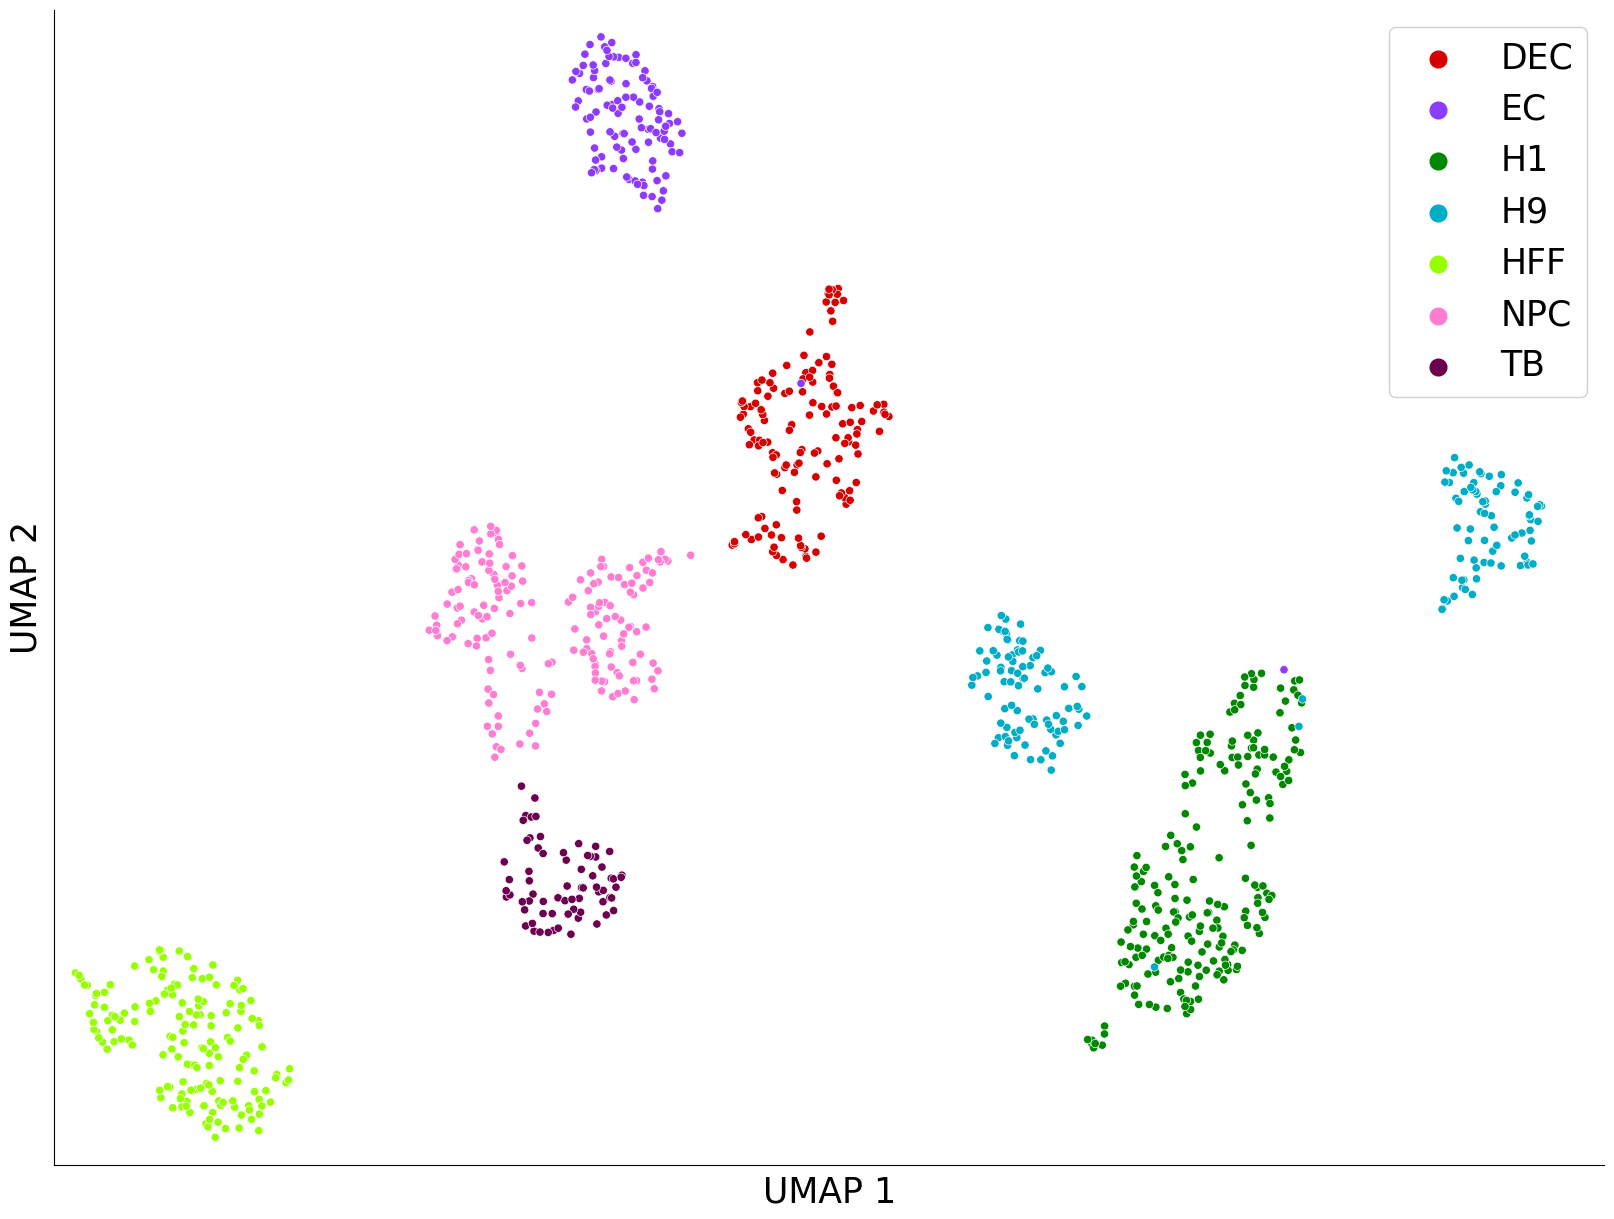

Adjusted Rand Index: 0.8555689276938827
Normalized Mutual Information: 0.9162657956580494
Silhouette Coefficient: 0.6672443151473999


/Users/yufeideng/Documents/GitHub/bis687-project/sc-env/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


(0.8555689276938827, 0.9162657956580494, 0.6672443)

In [61]:
random_seed = [1111,22222,3333,4444,5555,6666,7777,8888,9999]
end_label = [label.split("_")[0] for label in endoderm_scdm.index.to_list()]
calculate_cluster_results(endoderm_scdm.loc[:,adata.var.highly_variable],
                        end_label, 1111)